This notebook has been inspired from [REINFORCE-CartPole](https://colab.research.google.com/github/goodboychan/goodboychan.github.io/blob/main/_notebooks/2021-05-12-REINFORCE-CartPole.ipynb#scrollTo=V4fcuCO2v-wf) and [goodboychan.github.io](https://github.com/goodboychan/goodboychan.github.io/tree/main) by Chanseok Kang [Policy Graidient](https://colab.research.google.com/github/huggingface/deep-rl-class/blob/master/notebooks/unit4/unit4.ipynb) by Thomas Simonini.

# REINFORCE

In this notebook, we will implement REINFORCE algorithm for Cart Pole Environment.

## Cartpole

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

![Cartpole](https://gymnasium.farama.org/_images/cart_pole.gif)

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep until the psoition of the rod is correct (not inclined too far away from the vertical position).

The episode ends if any one of the following occurs:
- Pole Angle is greater than ±12°
- Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- Episode length is greater than 500 (200 for v0)

The state is low dimensional and consists of:
* position
* velocity
* angle
* angular velocity

You can read more the cartpole environment [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

## REINFORCE

REINFORCE is an elegant algorithm for maximizing the expected return. We sample a trajectory $\tau$ . If we get a high reward, we try to make it more likely. If we get a low reward, we try to make it less likely.

We just need a policy that maximizes the expected return and we can do this by Gradient Ascent on Policy parameters.

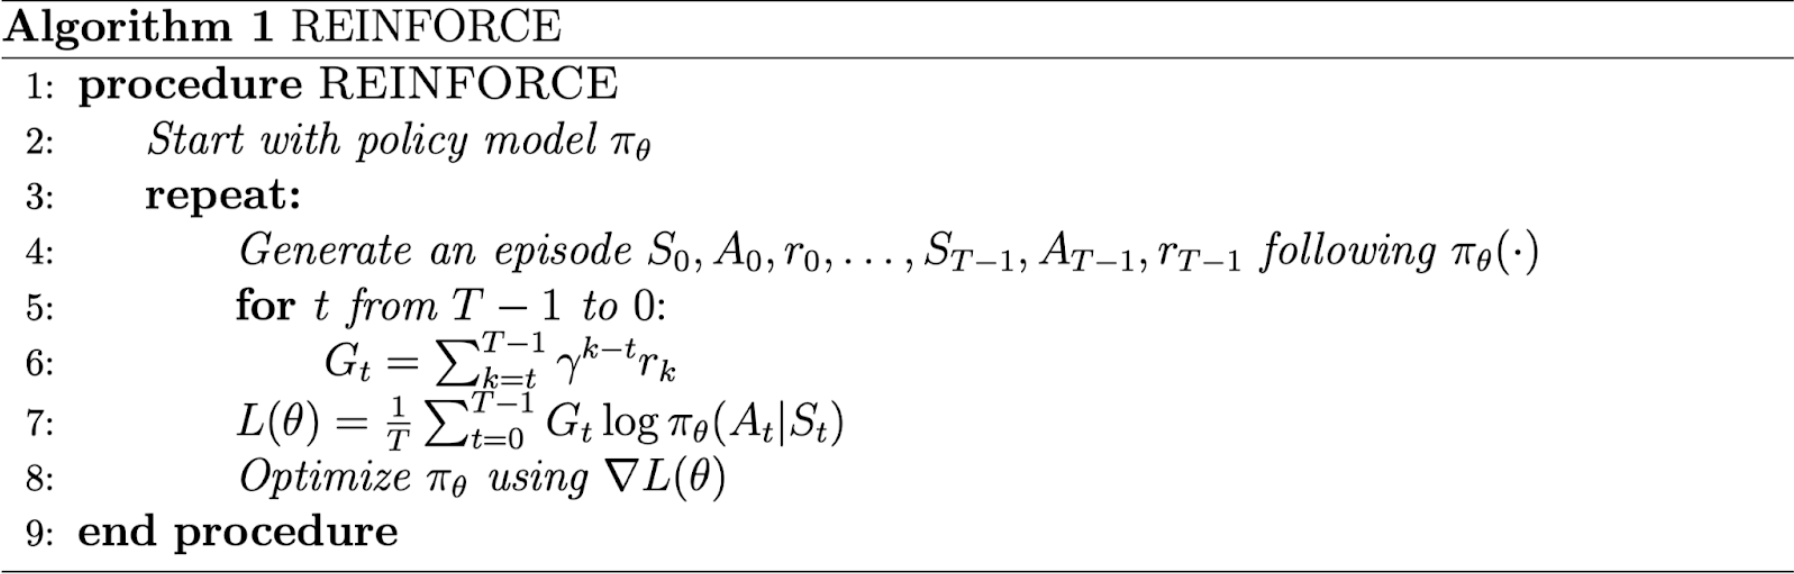


[Image Source](https://colab.research.google.com/github/huggingface/deep-rl-class/blob/master/notebooks/unit4/unit4.ipynb)

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create the environment
env = gym.make("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Policy Network

In [ ]:
# A neural network for policy
# It takes the state as input and predicts the probability of each action
class Policy(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Policy, self).__init__()
        #To Do: Define the structure of your network

    def forward(self, x):
        #To Do: Define the forward pass of the network.

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

### Hyperparameters

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 500        # Total training episodes
max_steps = 200              # Max steps per episode
learning_rate = #To DO: please specify the learning rate
gamma = 0.99                 # Discounting rate

### Training

In [ ]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
state size: 4
action size: 2


In [ ]:
# Intialize policy network
policy_net = Policy(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [ ]:
scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # To Do: sample action and its log probability from policy

    # To Do: save the log probability for later use

    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        break

  scores.append(sum(rewards))

  # Compute the discounted returns at each timestep
  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)
  # We will use the dynamic programming approach to reduce complexity of this operation.
  # We calculate from last to first and avoid redundant computations that would be needed
  # if we were to do it from first to last.

  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t]   )

  ## standardization of the returns is employed to make training more stable
  eps = np.finfo(np.float32).eps.item()
  ## eps is the smallest representable float, which is
  # added to the standard deviation of the returns to avoid numerical instabilities
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  # Calculating policy loss:
  policy_loss = []
  for log_prob, disc_return in zip(saved_log_probs, returns):
       # To Do: Calculate the policy loss please note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.

  policy_loss = torch.cat(policy_loss).sum()

  # Back propagation
  optimizer.zero_grad()
  policy_loss.backward()
  optimizer.step()

  print(f"Episode {episode}: Reward = {scores[-1]}")


Episode 1: Reward = 48.0
Episode 2: Reward = 12.0
Episode 3: Reward = 16.0
Episode 4: Reward = 22.0
Episode 5: Reward = 9.0
Episode 6: Reward = 19.0
Episode 7: Reward = 13.0
Episode 8: Reward = 38.0
Episode 9: Reward = 14.0
Episode 10: Reward = 23.0
Episode 11: Reward = 16.0
Episode 12: Reward = 24.0
Episode 13: Reward = 13.0
Episode 14: Reward = 28.0
Episode 15: Reward = 18.0
Episode 16: Reward = 19.0
Episode 17: Reward = 16.0
Episode 18: Reward = 15.0
Episode 19: Reward = 22.0
Episode 20: Reward = 23.0
Episode 21: Reward = 25.0
Episode 22: Reward = 48.0
Episode 23: Reward = 24.0
Episode 24: Reward = 10.0
Episode 25: Reward = 29.0
Episode 26: Reward = 16.0
Episode 27: Reward = 29.0
Episode 28: Reward = 35.0
Episode 29: Reward = 35.0
Episode 30: Reward = 11.0
Episode 31: Reward = 13.0
Episode 32: Reward = 26.0
Episode 33: Reward = 13.0
Episode 34: Reward = 24.0
Episode 35: Reward = 13.0
Episode 36: Reward = 22.0
Episode 37: Reward = 52.0
Episode 38: Reward = 24.0
Episode 39: Reward = 1

Text(0, 0.5, 'Reward')

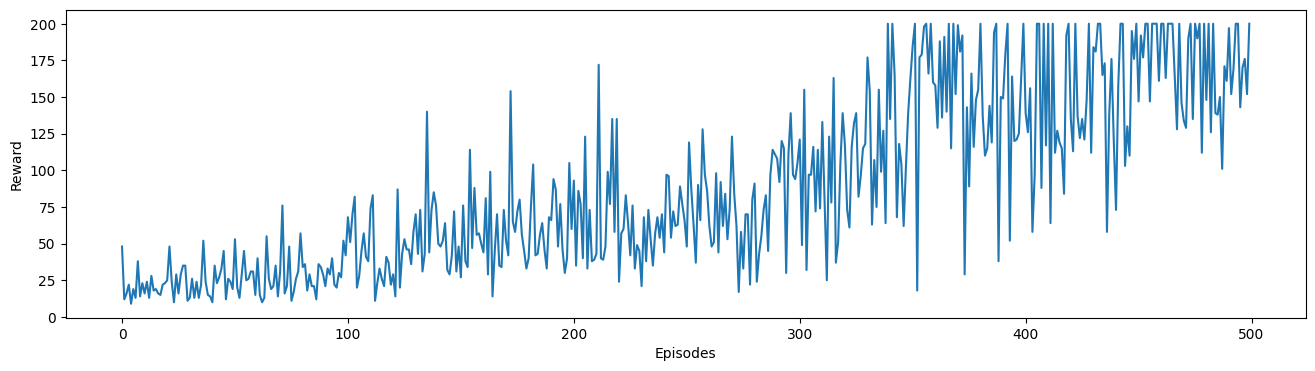

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _ = policy_net.act(state)
        next_state, reward, done, info = env.step(action)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [ ]:
show_video_of_model("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
S

In [ ]:
show_video("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
